# Cloud-Filtered Custom Mosaics

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

Median = midpoint of spectral data
Geomedian = Australian median product with improved spectral consistency
Most-Recent = most-recent clear pixel
Max-NDVI = maximum vegetation response

Users should review the "Cloud_Statistics" notebook for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app = 'my_app')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

In [3]:
## LS8 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '2013-04-13', '2018-03-26'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS8 Vietnam
# Latitude:  (10.513927001104687, 12.611133863411238)  
# Longitude: (106.79005909290998, 108.91906631627438)  
# '2014-01-14', '2016-12-21'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Caqueta
# Latitude:  (0.000134747292617865, 1.077843593651382)  
# Longitude: (-74.91935994831539, -73.30266193148462)  
# '1999-08-21', '2018-03-25'
# Resolution: (-0.000269494585236, 0.000269494585236)

## LS7 Lake Baringo
# Latitude:  (0.4997747685, 0.7495947795)  
# Longitude: (35.9742163305, 36.473586859499996)  
# '2005-01-08', '2016-12-24'
# Resolution: (-0.000269493, 0.000269493)

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a Product and Platform
# product = ls7_collection1_AMA_ingest
# platform = "LANDSAT_7"
product = 'ls7_collection1_AMA_ingest'
platform = "LANDSAT_7"

output_crs = 'EPSG:4326'
resolution = (-0.000269494585236, 0.000269494585236)

In [5]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>
# Select an analysis region (Lat-Lon) within the extents listed above. 
# HINT: Keep your region small (<0.5 deg square) to avoid memory overload issues
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

#Sub-region selection
latitude  = (0.49964002, 0.74964002)
longitude = (36.0, 36.3)
time_extents = ('2016-01-01', '2018-01-01')

In [6]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load the dataset and the required spectral bands and QA parameters

In [7]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          output_crs = output_crs,
                          resolution = resolution,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [8]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 928, longitude: 1114, time: 18)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-07T07:50:28 2016-01-23T07:50:41 ...
  * latitude   (latitude) float64 0.7496 0.7493 0.7491 0.7488 0.7485 0.7483 ...
  * longitude  (longitude) float64 36.0 36.0 36.0 36.0 36.0 36.0 36.0 36.0 ...
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    pixel_qa   (time, latitude, longitude) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:4326

>### Masking out Clouds

In [9]:
import xarray as xr  
import numpy as np

In [10]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)

> **Median Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series  

In [11]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

In [12]:
from utils.data_cube_utilities.dc_rgb import rgb

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5120cff2b0>)

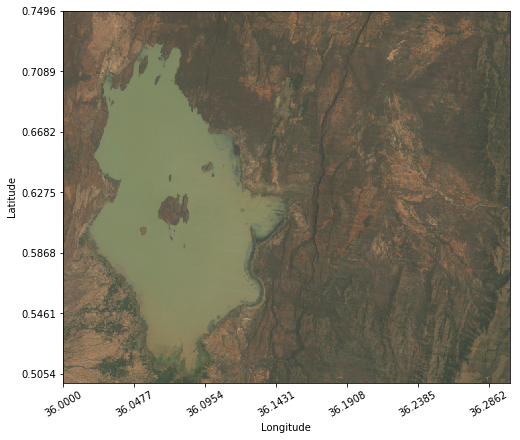

In [13]:
rgb(median_composite, max_possible=3000)

> **GeoMedian Mosaic**  
>  Masks clouds from imagery using the median valued cloud-free pixels in the time series while maintaining the spectral band relationships. This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 
<br><br>
For more information, see the following paper: High-Dimensional Pixel Composites from Earth Observation Time Series, by, Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

In [14]:
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
geomedian_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f511dc43fd0>)

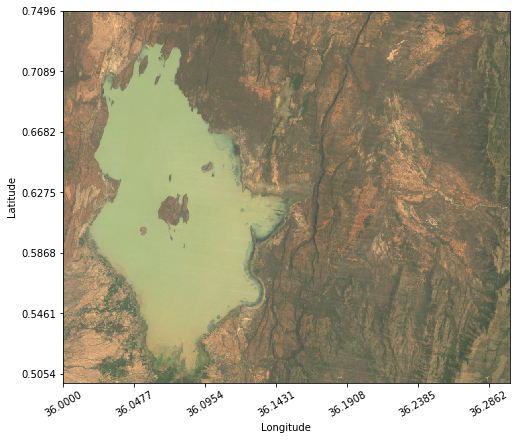

In [15]:
rgb(geomedian_composite, max_possible=2000)

> **Most Recent Mosaic**  
>  Masks clouds from imagery using the most recent cloud-free pixels in the time series  

In [16]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic
most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f511c39e278>)

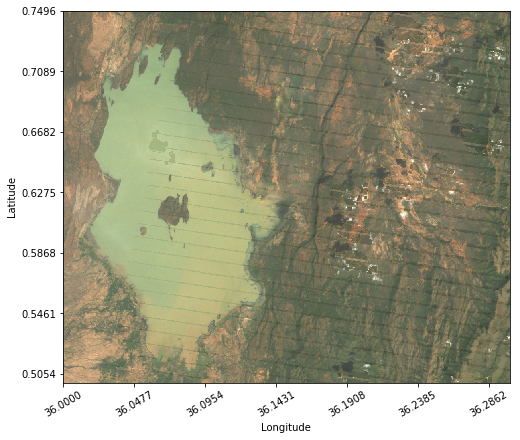

In [17]:
rgb(most_recent_composite, max_possible=2000)

> **Max NDVI Mosaic**  
>  Masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series  

In [18]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f511c39eb70>)

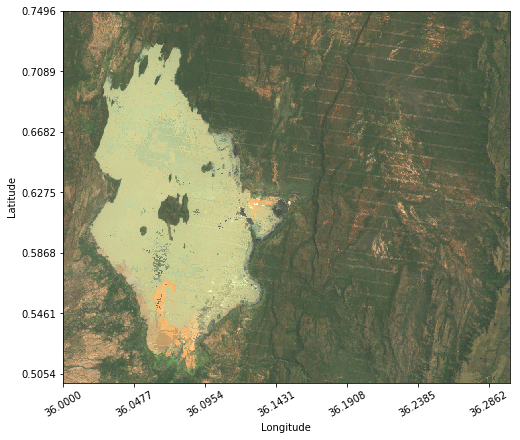

In [19]:
rgb(max_ndvi_composite, max_possible=2000)

>### Export to GeoTIFF

In [20]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

In [21]:
# CHANGE HERE >>>>>>>>>>>>>

# Remove the comment tags (#) to export a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 

#export_slice_to_geotiff(median_composite, 'geotiffs/DEMO_median_composite.tif')
#export_slice_to_geotiff(geomedian_composite, 'geotiffs/DEMO_geomedian_composite.tif')
#export_slice_to_geotiff(most_recent_composite, 'geotiffs/DEMO_most_recent_composite.tif')
#export_slice_to_geotiff(max_ndvi_composite, 'geotiffs/DEMO_max_ndvi_composite.tif')

In [22]:
!ls -lah geotiffs/

total 2.9M
drwxrwsr-x 2 1000 users 4.0K Jan 14 04:40 .
drwxrwsr-x 6 1000 users 4.0K Jan 14 11:20 ..
-rw-rw-r-- 1 1000 users 1.7M Jan 14 00:16 DEMO_median_composite.tif
-rw-rw-r-- 1 1000 users 1.2M Jan 14 04:40 WOFS_Percentage_demo.tif
